- Hatmap
- Melhorar o plot de imagens
- Propor algo novo

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from googlenet_pytorch import GoogLeNet 


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [3]:
test = 2

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [5]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            writer.add_scalar('training loss', loss, global_step=step)
            writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy and Loss in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [7]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    #
    #googlenet, shufflenet, mobilenet 
    #

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "shufflenet":
        """ shufflenet
        """
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "mobilenet":
        """ mobilenet
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "googlenet":
        """ googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [10]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 1.0955 Acc: 0.3869
val Loss: 1.0924 Acc: 0.4375

Epoch 1/299
----------
train Loss: 1.0895 Acc: 0.6592
val Loss: 1.0883 Acc: 0.7397

Epoch 2/299
----------
train Loss: 1.0841 Acc: 0.6713
val Loss: 1.0837 Acc: 0.7377

Epoch 3/299
----------
train Loss: 1.0789 Acc: 0.6654
val Loss: 1.0803 Acc: 0.6654

Epoch 4/299
----------
train Loss: 1.0738 Acc: 0.6846
val Loss: 1.0739 Acc: 0.7049

Epoch 5/299
----------
train Loss: 1.0691 Acc: 0.6790
val Loss: 1.0699 Acc: 0.7065

Epoch 6/299
----------
train Loss: 1.0635 Acc: 0.6819
val Loss: 1.0692 Acc: 0.7293

Epoch 7/299
----------
train Loss: 1.0584 Acc: 0.7028
val Loss: 1.0616 Acc: 0.7725

Epoch 8/299
----------
train Loss: 1.0542 Acc: 0.7118
val Loss: 1.0457 Acc: 0.8211

Epoch 9/299
-

train Loss: 0.7726 Acc: 0.8635
val Loss: 0.8423 Acc: 0.7584

Epoch 94/299
----------
train Loss: 0.7670 Acc: 0.8676
val Loss: 0.8163 Acc: 0.7958

Epoch 95/299
----------
train Loss: 0.7651 Acc: 0.8660
val Loss: 0.8263 Acc: 0.7862

Epoch 96/299
----------
train Loss: 0.7664 Acc: 0.8623
val Loss: 0.7967 Acc: 0.8261

Epoch 97/299
----------
train Loss: 0.7619 Acc: 0.8589
val Loss: 0.8447 Acc: 0.7356

Epoch 98/299
----------
train Loss: 0.7598 Acc: 0.8642
val Loss: 0.7806 Acc: 0.8298

Epoch 99/299
----------
train Loss: 0.7609 Acc: 0.8631
val Loss: 0.7401 Acc: 0.8929

Epoch 100/299
----------
train Loss: 0.7554 Acc: 0.8584
val Loss: 0.8339 Acc: 0.7605

Epoch 101/299
----------
train Loss: 0.7591 Acc: 0.8591
val Loss: 0.8056 Acc: 0.7949

Epoch 102/299
----------
train Loss: 0.7536 Acc: 0.8615
val Loss: 0.7857 Acc: 0.8215

Epoch 103/299
----------
train Loss: 0.7472 Acc: 0.8636
val Loss: 0.7243 Acc: 0.9045

Epoch 104/299
----------
train Loss: 0.7486 Acc: 0.8630
val Loss: 0.8119 Acc: 0.7729


val Loss: 0.6821 Acc: 0.8066

Epoch 189/299
----------
train Loss: 0.6235 Acc: 0.8716
val Loss: 0.7197 Acc: 0.7696

Epoch 190/299
----------
train Loss: 0.6213 Acc: 0.8722
val Loss: 0.7035 Acc: 0.7783

Epoch 191/299
----------
train Loss: 0.6173 Acc: 0.8737
val Loss: 0.6941 Acc: 0.7850

Epoch 192/299
----------
train Loss: 0.6117 Acc: 0.8740
val Loss: 0.6662 Acc: 0.8236

Epoch 193/299
----------
train Loss: 0.6142 Acc: 0.8738
val Loss: 0.6703 Acc: 0.8041

Epoch 194/299
----------
train Loss: 0.6129 Acc: 0.8746
val Loss: 0.7010 Acc: 0.7821

Epoch 195/299
----------
train Loss: 0.6129 Acc: 0.8732
val Loss: 0.7137 Acc: 0.7667

Epoch 196/299
----------
train Loss: 0.6144 Acc: 0.8692
val Loss: 0.7616 Acc: 0.7223

Epoch 197/299
----------
train Loss: 0.6088 Acc: 0.8765
val Loss: 0.6387 Acc: 0.8456

Epoch 198/299
----------
train Loss: 0.6160 Acc: 0.8700
val Loss: 0.5552 Acc: 0.9157

Epoch 199/299
----------
train Loss: 0.6092 Acc: 0.8749
val Loss: 0.6898 Acc: 0.7837

Epoch 200/299
----------

train Loss: 0.5392 Acc: 0.8817
val Loss: 0.6817 Acc: 0.7493

Epoch 285/299
----------
train Loss: 0.5318 Acc: 0.8831
val Loss: 0.6580 Acc: 0.7680

Epoch 286/299
----------
train Loss: 0.5433 Acc: 0.8750
val Loss: 0.6421 Acc: 0.7854

Epoch 287/299
----------
train Loss: 0.5331 Acc: 0.8828
val Loss: 0.6846 Acc: 0.7493

Epoch 288/299
----------
train Loss: 0.5326 Acc: 0.8830
val Loss: 0.5032 Acc: 0.9012

Epoch 289/299
----------
train Loss: 0.5333 Acc: 0.8825
val Loss: 0.6206 Acc: 0.7983

Epoch 290/299
----------
train Loss: 0.5335 Acc: 0.8819
val Loss: 0.5664 Acc: 0.8385

Epoch 291/299
----------
train Loss: 0.5349 Acc: 0.8793
val Loss: 0.5980 Acc: 0.8107

Epoch 292/299
----------
train Loss: 0.5302 Acc: 0.8790
val Loss: 0.5467 Acc: 0.8522

Epoch 293/299
----------
train Loss: 0.5316 Acc: 0.8820
val Loss: 0.5830 Acc: 0.8286

Epoch 294/299
----------
train Loss: 0.5334 Acc: 0.8784
val Loss: 0.6441 Acc: 0.7725

Epoch 295/299
----------
train Loss: 0.5327 Acc: 0.8795
val Loss: 0.5241 Acc: 0

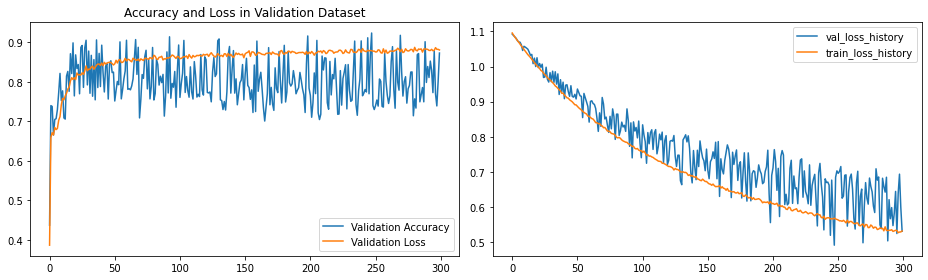


==== END ====
[[762   7  22]
 [  7 736  56]
 [ 10  83 726]]

Sensitivity or recall total
0.9232046492320465

Sensitivity or recall per classes
[0.96333755 0.92115144 0.88644689]

Precision
[0.97817715 0.89104116 0.90298507]

F1 Score
[0.97070064 0.90584615 0.89463956]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -0.2553 Acc: 0.4849
val Loss: -0.4915 Acc: 0.5654

Epoch 1/299
----------
train Loss: -0.7781 Acc: 0.5907
val Loss: -0.9974 Acc: 0.4288

Epoch 2/299
----------
train Loss: -1.3010 Acc: 0.5734
val Loss: -1.5000 Acc: 0.4765

Epoch 3/299
----------
train Loss: -1.8240 Acc: 0.5614
val Loss: -1.9840 Acc: 0.4467

Epoch 4/299
----------
train Loss: -2.3468 Acc: 0.5893
val Loss: -2.4620 Acc: 0.4176

Epoch 5/299
----------
train 

train Loss: -45.2210 Acc: 0.5563
val Loss: -43.1628 Acc: 0.4047

Epoch 87/299
----------
train Loss: -45.7421 Acc: 0.5614
val Loss: -43.2378 Acc: 0.3665

Epoch 88/299
----------
train Loss: -46.2640 Acc: 0.5598
val Loss: -44.2660 Acc: 0.4305

Epoch 89/299
----------
train Loss: -46.7868 Acc: 0.5573
val Loss: -44.7829 Acc: 0.3823

Epoch 90/299
----------
train Loss: -47.3124 Acc: 0.5560
val Loss: -45.9770 Acc: 0.4948

Epoch 91/299
----------
train Loss: -47.8336 Acc: 0.5609
val Loss: -46.3583 Acc: 0.4965

Epoch 92/299
----------
train Loss: -48.3603 Acc: 0.5591
val Loss: -46.4411 Acc: 0.4408

Epoch 93/299
----------
train Loss: -48.8818 Acc: 0.5587
val Loss: -46.8089 Acc: 0.4247

Epoch 94/299
----------
train Loss: -49.4043 Acc: 0.5612
val Loss: -48.4048 Acc: 0.5073

Epoch 95/299
----------
train Loss: -49.9242 Acc: 0.5585
val Loss: -48.1286 Acc: 0.4699

Epoch 96/299
----------
train Loss: -50.4507 Acc: 0.5591
val Loss: -47.8850 Acc: 0.3661

Epoch 97/299
----------
train Loss: -50.9669 

val Loss: -89.2487 Acc: 0.4479

Epoch 178/299
----------
train Loss: -93.3202 Acc: 0.5575
val Loss: -88.6036 Acc: 0.4147

Epoch 179/299
----------
train Loss: -93.8368 Acc: 0.5561
val Loss: -89.1212 Acc: 0.3599

Epoch 180/299
----------
train Loss: -94.3656 Acc: 0.5555
val Loss: -89.1463 Acc: 0.3931

Epoch 181/299
----------
train Loss: -94.8895 Acc: 0.5550
val Loss: -90.0374 Acc: 0.3773

Epoch 182/299
----------
train Loss: -95.4170 Acc: 0.5553
val Loss: -91.6509 Acc: 0.4770

Epoch 183/299
----------
train Loss: -95.9304 Acc: 0.5583
val Loss: -92.2663 Acc: 0.4288

Epoch 184/299
----------
train Loss: -96.4524 Acc: 0.5586
val Loss: -93.2319 Acc: 0.4803

Epoch 185/299
----------
train Loss: -96.9847 Acc: 0.5619
val Loss: -91.9722 Acc: 0.4006

Epoch 186/299
----------
train Loss: -97.4998 Acc: 0.5628
val Loss: -93.5875 Acc: 0.4932

Epoch 187/299
----------
train Loss: -98.0331 Acc: 0.5562
val Loss: -95.7445 Acc: 0.5118

Epoch 188/299
----------
train Loss: -98.5379 Acc: 0.5574
val Loss: 

train Loss: -139.8597 Acc: 0.5554
val Loss: -132.8686 Acc: 0.3985

Epoch 268/299
----------
train Loss: -140.3633 Acc: 0.5591
val Loss: -133.1608 Acc: 0.3769

Epoch 269/299
----------
train Loss: -140.9086 Acc: 0.5617
val Loss: -134.0305 Acc: 0.3686

Epoch 270/299
----------
train Loss: -141.4128 Acc: 0.5589
val Loss: -133.3823 Acc: 0.3865

Epoch 271/299
----------
train Loss: -141.9385 Acc: 0.5556
val Loss: -133.9761 Acc: 0.3802

Epoch 272/299
----------
train Loss: -142.4648 Acc: 0.5576
val Loss: -136.7206 Acc: 0.4267

Epoch 273/299
----------
train Loss: -143.0020 Acc: 0.5586
val Loss: -135.9741 Acc: 0.4110

Epoch 274/299
----------
train Loss: -143.5160 Acc: 0.5576
val Loss: -136.3420 Acc: 0.3968

Epoch 275/299
----------
train Loss: -144.0482 Acc: 0.5630
val Loss: -138.2067 Acc: 0.4197

Epoch 276/299
----------
train Loss: -144.5557 Acc: 0.5572
val Loss: -139.8585 Acc: 0.4732

Epoch 277/299
----------
train Loss: -145.0883 Acc: 0.5593
val Loss: -138.1077 Acc: 0.3657

Epoch 278/299

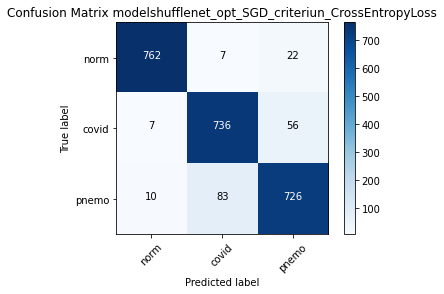

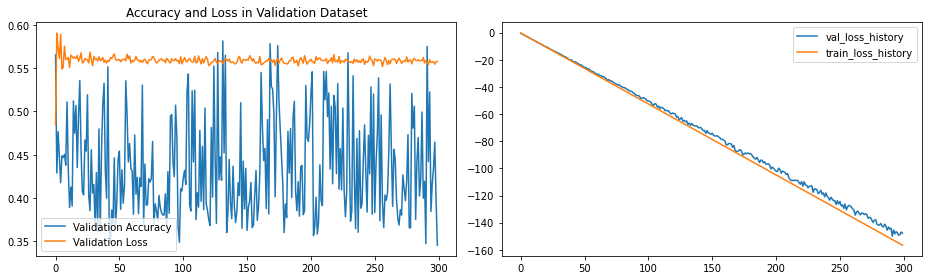


==== END ====
[[791   0   0]
 [189 610   0]
 [759  60   0]]

Sensitivity or recall total
0.5815691158156912

Sensitivity or recall per classes
[1.   0.76 0.  ]

Precision
[0.45 0.91 0.  ]

F1 Score
[0.63 0.83 0.  ]
Confusion matrix, without normalization


/home/jimi/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 1.0416 Acc: 0.6536
val Loss: 1.0142 Acc: 0.7356

Epoch 1/299
----------
train Loss: 0.9400 Acc: 0.7659
val Loss: 0.9149 Acc: 0.8809

Epoch 2/299
----------
train Loss: 0.8615 Acc: 0.8305
val Loss: 0.8915 Acc: 0.8028

Epoch 3/299
----------
train Loss: 0.7900 Acc: 0.8463
val Loss: 0.7914 Acc: 0.8850

Epoch 4/299
----------
train Loss: 0.7351 Acc: 0.8642
val Loss: 0.7844 Acc: 0.8157

Epoch 5/299
----------
train Loss: 0.6880 Acc: 0.8742
val Loss: 0.6962 Acc: 0.8888

Epoch 6/299
----------
train Loss: 0.6441 Acc: 0.8824
val Loss: 0.6903 Acc: 0.8726

Epoch 7/299
----------
train Loss: 0.6120 Acc: 0.8822
val Loss: 0.5622 Acc: 0.9294

Epoch 8/299
----------
train Loss: 0.5833 Acc: 0.8848
val Loss: 0.5233 Acc: 0.9298

Epoch 9/299
-

train Loss: 0.2358 Acc: 0.9242
val Loss: 0.2712 Acc: 0.8975

Epoch 94/299
----------
train Loss: 0.2469 Acc: 0.9200
val Loss: 0.3122 Acc: 0.8738

Epoch 95/299
----------
train Loss: 0.2395 Acc: 0.9231
val Loss: 0.1664 Acc: 0.9597

Epoch 96/299
----------
train Loss: 0.2370 Acc: 0.9275
val Loss: 0.3282 Acc: 0.8667

Epoch 97/299
----------
train Loss: 0.2329 Acc: 0.9235
val Loss: 0.4103 Acc: 0.8086

Epoch 98/299
----------
train Loss: 0.2320 Acc: 0.9276
val Loss: 0.3796 Acc: 0.8269

Epoch 99/299
----------
train Loss: 0.2296 Acc: 0.9279
val Loss: 0.2246 Acc: 0.9249

Epoch 100/299
----------
train Loss: 0.2300 Acc: 0.9273
val Loss: 0.2157 Acc: 0.9319

Epoch 101/299
----------
train Loss: 0.2241 Acc: 0.9302
val Loss: 0.3827 Acc: 0.8240

Epoch 102/299
----------
train Loss: 0.2307 Acc: 0.9282
val Loss: 0.3614 Acc: 0.8414

Epoch 103/299
----------
train Loss: 0.2309 Acc: 0.9251
val Loss: 0.2752 Acc: 0.8971

Epoch 104/299
----------
train Loss: 0.2350 Acc: 0.9230
val Loss: 0.2639 Acc: 0.9008


val Loss: 0.2184 Acc: 0.9191

Epoch 189/299
----------
train Loss: 0.1944 Acc: 0.9346
val Loss: 0.2101 Acc: 0.9215

Epoch 190/299
----------
train Loss: 0.1982 Acc: 0.9351
val Loss: 0.1535 Acc: 0.9539

Epoch 191/299
----------
train Loss: 0.1993 Acc: 0.9337
val Loss: 0.2824 Acc: 0.8775

Epoch 192/299
----------
train Loss: 0.2057 Acc: 0.9319
val Loss: 0.2238 Acc: 0.9124

Epoch 193/299
----------
train Loss: 0.2001 Acc: 0.9329
val Loss: 0.2532 Acc: 0.8995

Epoch 194/299
----------
train Loss: 0.1991 Acc: 0.9328
val Loss: 0.1791 Acc: 0.9402

Epoch 195/299
----------
train Loss: 0.1992 Acc: 0.9336
val Loss: 0.1907 Acc: 0.9307

Epoch 196/299
----------
train Loss: 0.1948 Acc: 0.9381
val Loss: 0.2617 Acc: 0.8900

Epoch 197/299
----------
train Loss: 0.1899 Acc: 0.9382
val Loss: 0.2441 Acc: 0.9004

Epoch 198/299
----------
train Loss: 0.1907 Acc: 0.9366
val Loss: 0.2579 Acc: 0.8929

Epoch 199/299
----------
train Loss: 0.2047 Acc: 0.9310
val Loss: 0.2050 Acc: 0.9240

Epoch 200/299
----------

train Loss: 0.1815 Acc: 0.9380
val Loss: 0.1552 Acc: 0.9489

Epoch 285/299
----------
train Loss: 0.1836 Acc: 0.9400
val Loss: 0.3554 Acc: 0.8315

Epoch 286/299
----------
train Loss: 0.1823 Acc: 0.9372
val Loss: 0.2667 Acc: 0.8838

Epoch 287/299
----------
train Loss: 0.1864 Acc: 0.9371
val Loss: 0.2560 Acc: 0.8867

Epoch 288/299
----------
train Loss: 0.1788 Acc: 0.9384
val Loss: 0.2408 Acc: 0.8971

Epoch 289/299
----------
train Loss: 0.1704 Acc: 0.9441
val Loss: 0.1226 Acc: 0.9614

Epoch 290/299
----------
train Loss: 0.1790 Acc: 0.9422
val Loss: 0.3046 Acc: 0.8618

Epoch 291/299
----------
train Loss: 0.1839 Acc: 0.9372
val Loss: 0.1677 Acc: 0.9406

Epoch 292/299
----------
train Loss: 0.1819 Acc: 0.9377
val Loss: 0.1791 Acc: 0.9361

Epoch 293/299
----------
train Loss: 0.1849 Acc: 0.9387
val Loss: 0.1713 Acc: 0.9406

Epoch 294/299
----------
train Loss: 0.1766 Acc: 0.9427
val Loss: 0.3019 Acc: 0.8663

Epoch 295/299
----------
train Loss: 0.1785 Acc: 0.9379
val Loss: 0.1187 Acc: 0

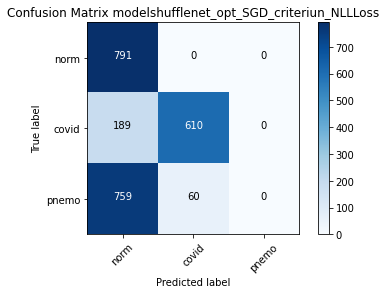

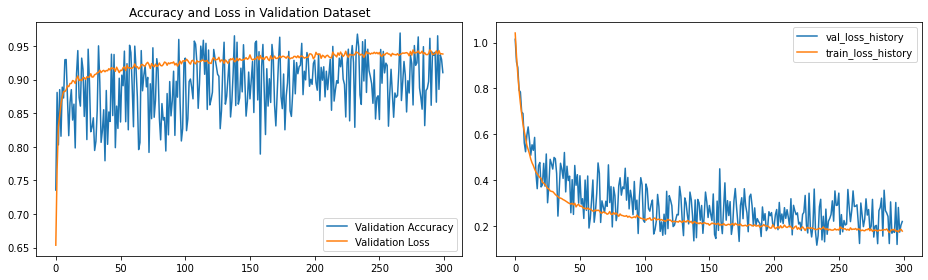


==== END ====
[[788   0   3]
 [  0 762  37]
 [  0  34 785]]

Sensitivity or recall total
0.9692818596928185

Sensitivity or recall per classes
[1.   0.95 0.96]

Precision
[1.   0.96 0.95]

F1 Score
[1.   0.96 0.95]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -0.9206 Acc: 0.4002
val Loss: -1.5063 Acc: 0.5093

Epoch 1/299
----------
train Loss: -2.7298 Acc: 0.5734
val Loss: -2.8274 Acc: 0.4932

Epoch 2/299
----------
train Loss: -4.5414 Acc: 0.6320
val Loss: -4.3016 Acc: 0.6189

Epoch 3/299
----------
train Loss: -6.3508 Acc: 0.6258
val Loss: -5.5469 Acc: 0.5832

Epoch 4/299
----------
train Loss: -8.1627 Acc: 0.6097
val Loss: -7.1757 Acc: 0.6135

Epoch 5/299
----------
train Loss: -9.9707 Acc: 0.6266
val Loss: -8.7939 Acc: 0.631

val Loss: -123.8125 Acc: 0.6276

Epoch 86/299
----------
train Loss: -156.4195 Acc: 0.6174
val Loss: -120.3638 Acc: 0.6318

Epoch 87/299
----------
train Loss: -158.2711 Acc: 0.6134
val Loss: -126.9645 Acc: 0.6364

Epoch 88/299
----------
train Loss: -160.0406 Acc: 0.6170
val Loss: -127.3370 Acc: 0.6351

Epoch 89/299
----------
train Loss: -161.8609 Acc: 0.6166
val Loss: -125.1002 Acc: 0.6301

Epoch 90/299
----------
train Loss: -163.6245 Acc: 0.6173
val Loss: -132.6162 Acc: 0.6335

Epoch 91/299
----------
train Loss: -165.4773 Acc: 0.6168
val Loss: -127.3315 Acc: 0.6372

Epoch 92/299
----------
train Loss: -167.3051 Acc: 0.6183
val Loss: -137.2003 Acc: 0.6368

Epoch 93/299
----------
train Loss: -169.0748 Acc: 0.6177
val Loss: -134.3266 Acc: 0.6322

Epoch 94/299
----------
train Loss: -170.9254 Acc: 0.6154
val Loss: -143.0153 Acc: 0.6368

Epoch 95/299
----------
train Loss: -172.7085 Acc: 0.6200
val Loss: -137.4378 Acc: 0.6376

Epoch 96/299
----------
train Loss: -174.5747 Acc: 0.6180

train Loss: -317.4389 Acc: 0.6161
val Loss: -272.5816 Acc: 0.6376

Epoch 176/299
----------
train Loss: -319.3314 Acc: 0.6165
val Loss: -251.1917 Acc: 0.6318

Epoch 177/299
----------
train Loss: -321.0523 Acc: 0.6156
val Loss: -248.4969 Acc: 0.6347

Epoch 178/299
----------
train Loss: -322.8761 Acc: 0.6195
val Loss: -269.8587 Acc: 0.6368

Epoch 179/299
----------
train Loss: -324.6290 Acc: 0.6179
val Loss: -283.8393 Acc: 0.6401

Epoch 180/299
----------
train Loss: -326.4459 Acc: 0.6147
val Loss: -252.2528 Acc: 0.6384

Epoch 181/299
----------
train Loss: -328.3216 Acc: 0.6160
val Loss: -250.0391 Acc: 0.6347

Epoch 182/299
----------
train Loss: -330.1271 Acc: 0.6169
val Loss: -302.5932 Acc: 0.6389

Epoch 183/299
----------
train Loss: -331.7420 Acc: 0.6177
val Loss: -261.6262 Acc: 0.6384

Epoch 184/299
----------
train Loss: -333.6648 Acc: 0.6146
val Loss: -298.4835 Acc: 0.6355

Epoch 185/299
----------
train Loss: -335.5184 Acc: 0.6187
val Loss: -270.2966 Acc: 0.6330

Epoch 186/299

val Loss: -408.6960 Acc: 0.6326

Epoch 265/299
----------
train Loss: -480.0111 Acc: 0.6197
val Loss: -410.5637 Acc: 0.6384

Epoch 266/299
----------
train Loss: -482.0143 Acc: 0.6157
val Loss: -425.1793 Acc: 0.6306

Epoch 267/299
----------
train Loss: -483.6686 Acc: 0.6149
val Loss: -392.6669 Acc: 0.6368

Epoch 268/299
----------
train Loss: -485.5616 Acc: 0.6158
val Loss: -444.7633 Acc: 0.6372

Epoch 269/299
----------
train Loss: -487.2425 Acc: 0.6187
val Loss: -396.3773 Acc: 0.6389

Epoch 270/299
----------
train Loss: -489.2543 Acc: 0.6175
val Loss: -399.0802 Acc: 0.6347

Epoch 271/299
----------
train Loss: -490.9185 Acc: 0.6147
val Loss: -400.6216 Acc: 0.6355

Epoch 272/299
----------
train Loss: -492.7065 Acc: 0.6163
val Loss: -424.4713 Acc: 0.6372

Epoch 273/299
----------
train Loss: -494.5802 Acc: 0.6178
val Loss: -433.8249 Acc: 0.6335

Epoch 274/299
----------
train Loss: -496.3775 Acc: 0.6175
val Loss: -405.4983 Acc: 0.6355

Epoch 275/299
----------
train Loss: -498.2566 

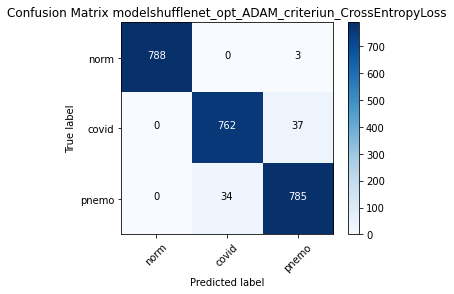

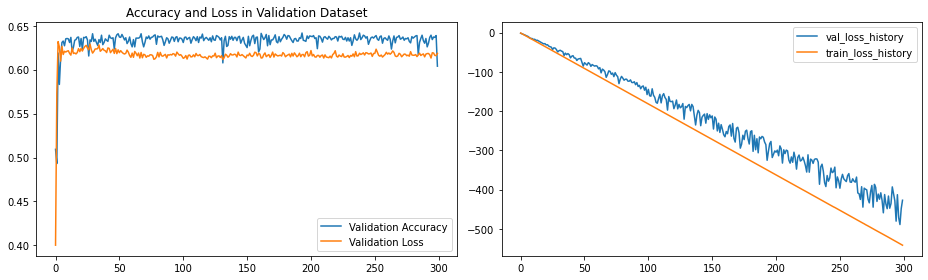


==== END ====
[[762  29   0]
 [ 15 784   0]
 [354 465   0]]

Sensitivity or recall total
0.6417600664176006

Sensitivity or recall per classes
[0.96 0.98 0.  ]

Precision
[0.67 0.61 0.  ]

F1 Score
[0.79 0.75 0.  ]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 1.0294 Acc: 0.6490
val Loss: 0.9888 Acc: 0.8286

Epoch 1/299
----------
train Loss: 0.9285 Acc: 0.7844
val Loss: 0.9006 Acc: 0.8975

Epoch 2/299
----------
train Loss: 0.8474 Acc: 0.8359
val Loss: 0.8351 Acc: 0.8950

Epoch 3/299
----------
train Loss: 0.7830 Acc: 0.8517
val Loss: 0.8013 Acc: 0.8618

Epoch 4/299
----------
train Loss: 0.7199 Acc: 0.8788
val Loss: 0.8151 Acc: 0.7808

Epoch 5/299
----------
train Loss: 0.6763 Acc: 0.8716
val Loss: 0.7347 Acc: 0.8302

Epoch 6/2

train Loss: 0.2368 Acc: 0.9265
val Loss: 0.4035 Acc: 0.8157

Epoch 91/299
----------
train Loss: 0.2399 Acc: 0.9249
val Loss: 0.2888 Acc: 0.8925

Epoch 92/299
----------
train Loss: 0.2372 Acc: 0.9248
val Loss: 0.2672 Acc: 0.8979

Epoch 93/299
----------
train Loss: 0.2282 Acc: 0.9269
val Loss: 0.3401 Acc: 0.8580

Epoch 94/299
----------
train Loss: 0.2342 Acc: 0.9236
val Loss: 0.3538 Acc: 0.8497

Epoch 95/299
----------
train Loss: 0.2356 Acc: 0.9266
val Loss: 0.3115 Acc: 0.8751

Epoch 96/299
----------
train Loss: 0.2351 Acc: 0.9251
val Loss: 0.1847 Acc: 0.9514

Epoch 97/299
----------
train Loss: 0.2356 Acc: 0.9229
val Loss: 0.4074 Acc: 0.8182

Epoch 98/299
----------
train Loss: 0.2346 Acc: 0.9235
val Loss: 0.2814 Acc: 0.8892

Epoch 99/299
----------
train Loss: 0.2299 Acc: 0.9281
val Loss: 0.3870 Acc: 0.8277

Epoch 100/299
----------
train Loss: 0.2319 Acc: 0.9276
val Loss: 0.3623 Acc: 0.8394

Epoch 101/299
----------
train Loss: 0.2345 Acc: 0.9243
val Loss: 0.3829 Acc: 0.8207

Ep

train Loss: 0.1951 Acc: 0.9364
val Loss: 0.3144 Acc: 0.8560

Epoch 187/299
----------
train Loss: 0.1881 Acc: 0.9400
val Loss: 0.3338 Acc: 0.8497

Epoch 188/299
----------
train Loss: 0.2025 Acc: 0.9317
val Loss: 0.1398 Acc: 0.9572

Epoch 189/299
----------
train Loss: 0.2007 Acc: 0.9333
val Loss: 0.3642 Acc: 0.8265

Epoch 190/299
----------
train Loss: 0.1943 Acc: 0.9368
val Loss: 0.3365 Acc: 0.8539

Epoch 191/299
----------
train Loss: 0.2041 Acc: 0.9301
val Loss: 0.3750 Acc: 0.8207

Epoch 192/299
----------
train Loss: 0.1934 Acc: 0.9359
val Loss: 0.3719 Acc: 0.8265

Epoch 193/299
----------
train Loss: 0.1960 Acc: 0.9332
val Loss: 0.3196 Acc: 0.8597

Epoch 194/299
----------
train Loss: 0.1968 Acc: 0.9320
val Loss: 0.1932 Acc: 0.9332

Epoch 195/299
----------
train Loss: 0.1945 Acc: 0.9352
val Loss: 0.1412 Acc: 0.9556

Epoch 196/299
----------
train Loss: 0.1941 Acc: 0.9367
val Loss: 0.2827 Acc: 0.8771

Epoch 197/299
----------
train Loss: 0.2002 Acc: 0.9347
val Loss: 0.2009 Acc: 0

val Loss: 0.1625 Acc: 0.9435

Epoch 282/299
----------
train Loss: 0.1786 Acc: 0.9382
val Loss: 0.1587 Acc: 0.9481

Epoch 283/299
----------
train Loss: 0.1741 Acc: 0.9403
val Loss: 0.1179 Acc: 0.9631

Epoch 284/299
----------
train Loss: 0.1828 Acc: 0.9367
val Loss: 0.1179 Acc: 0.9655

Epoch 285/299
----------
train Loss: 0.1772 Acc: 0.9404
val Loss: 0.1138 Acc: 0.9664

Epoch 286/299
----------
train Loss: 0.1781 Acc: 0.9385
val Loss: 0.1751 Acc: 0.9344

Epoch 287/299
----------
train Loss: 0.1816 Acc: 0.9394
val Loss: 0.2996 Acc: 0.8659

Epoch 288/299
----------
train Loss: 0.1804 Acc: 0.9364
val Loss: 0.1952 Acc: 0.9286

Epoch 289/299
----------
train Loss: 0.1773 Acc: 0.9399
val Loss: 0.3566 Acc: 0.8315

Epoch 290/299
----------
train Loss: 0.1795 Acc: 0.9409
val Loss: 0.1783 Acc: 0.9373

Epoch 291/299
----------
train Loss: 0.1822 Acc: 0.9390
val Loss: 0.2637 Acc: 0.8813

Epoch 292/299
----------
train Loss: 0.1782 Acc: 0.9421
val Loss: 0.2108 Acc: 0.9149

Epoch 293/299
----------

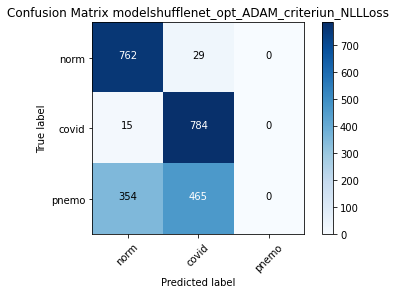

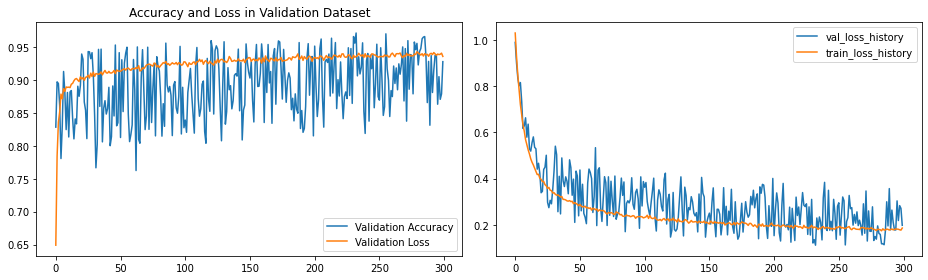


==== END ====
[[789   0   2]
 [  0 769  30]
 [  0  36 783]]

Sensitivity or recall total
0.9717725197177252

Sensitivity or recall per classes
[1.   0.96 0.96]

Precision
[1.   0.96 0.96]

F1 Score
[1.   0.96 0.96]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> shufflenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 2

--------------------
Params to learn:
	 fc.weight
	 fc.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -1.0762 Acc: 0.3450
val Loss: -1.5641 Acc: 0.4330

Epoch 1/299
----------
train Loss: -2.8844 Acc: 0.4127
val Loss: -2.9917 Acc: 0.6156

Epoch 2/299
----------
train Loss: -4.6872 Acc: 0.5305
val Loss: -4.7035 Acc: 0.6193

Epoch 3/299
----------
train Loss: -6.4861 Acc: 0.5691
val Loss: -5.8288 Acc: 0.6326

Epoch 4/299
----------
train Loss: -8.2927 Acc: 0.5836
val Loss: -7.3366 Acc: 0.6384

Epoch 5/299
----------
train Loss: -10.1061 Acc: 0.5916
val Loss: -9.3618 Acc: 0.61

val Loss: -140.3091 Acc: 0.6272

Epoch 86/299
----------
train Loss: -156.3804 Acc: 0.6142
val Loss: -124.0628 Acc: 0.6380

Epoch 87/299
----------
train Loss: -158.1904 Acc: 0.6149
val Loss: -129.0068 Acc: 0.6389

Epoch 88/299
----------
train Loss: -160.0362 Acc: 0.6174
val Loss: -128.6947 Acc: 0.6322

Epoch 89/299
----------
train Loss: -161.7478 Acc: 0.6170
val Loss: -130.0322 Acc: 0.6198

Epoch 90/299
----------
train Loss: -163.6482 Acc: 0.6158
val Loss: -144.2580 Acc: 0.6405

Epoch 91/299
----------
train Loss: -165.4342 Acc: 0.6145
val Loss: -137.9249 Acc: 0.6384

Epoch 92/299
----------
train Loss: -167.2650 Acc: 0.6186
val Loss: -145.5723 Acc: 0.6330

Epoch 93/299
----------
train Loss: -169.0086 Acc: 0.6175
val Loss: -137.9338 Acc: 0.6326

Epoch 94/299
----------
train Loss: -170.8064 Acc: 0.6178
val Loss: -138.1464 Acc: 0.6351

Epoch 95/299
----------
train Loss: -172.6733 Acc: 0.6173
val Loss: -141.7653 Acc: 0.6376

Epoch 96/299
----------
train Loss: -174.4809 Acc: 0.6120

train Loss: -317.1354 Acc: 0.6165
val Loss: -267.8028 Acc: 0.6347

Epoch 176/299
----------
train Loss: -318.9459 Acc: 0.6163
val Loss: -276.2795 Acc: 0.6384

Epoch 177/299
----------
train Loss: -320.7457 Acc: 0.6187
val Loss: -291.1539 Acc: 0.6310

Epoch 178/299
----------
train Loss: -322.5111 Acc: 0.6150
val Loss: -299.5919 Acc: 0.6318

Epoch 179/299
----------
train Loss: -324.2365 Acc: 0.6158
val Loss: -280.9398 Acc: 0.6139

Epoch 180/299
----------
train Loss: -326.1739 Acc: 0.6188
val Loss: -258.6220 Acc: 0.6268

Epoch 181/299
----------
train Loss: -327.9363 Acc: 0.6190
val Loss: -262.5171 Acc: 0.6355

Epoch 182/299
----------
train Loss: -329.8326 Acc: 0.6170
val Loss: -256.7933 Acc: 0.6372

Epoch 183/299
----------
train Loss: -331.5456 Acc: 0.6146
val Loss: -255.7817 Acc: 0.6169

Epoch 184/299
----------
train Loss: -333.4589 Acc: 0.6193
val Loss: -260.2422 Acc: 0.6376

Epoch 185/299
----------
train Loss: -335.2501 Acc: 0.6160
val Loss: -269.6524 Acc: 0.6330

Epoch 186/299

val Loss: -413.0086 Acc: 0.6359

Epoch 265/299
----------
train Loss: -479.5590 Acc: 0.6160
val Loss: -372.5850 Acc: 0.6347

Epoch 266/299
----------
train Loss: -481.6722 Acc: 0.6179
val Loss: -392.5197 Acc: 0.6355

Epoch 267/299
----------
train Loss: -483.2514 Acc: 0.6129
val Loss: -390.9320 Acc: 0.6347

Epoch 268/299
----------
train Loss: -485.1086 Acc: 0.6168
val Loss: -381.9737 Acc: 0.6335

Epoch 269/299
----------
train Loss: -486.9972 Acc: 0.6177
val Loss: -398.7941 Acc: 0.6347

Epoch 270/299
----------
train Loss: -488.8052 Acc: 0.6156
val Loss: -424.6705 Acc: 0.6384

Epoch 271/299
----------
train Loss: -490.4772 Acc: 0.6151
val Loss: -393.7515 Acc: 0.6335

Epoch 272/299
----------
train Loss: -492.1808 Acc: 0.6120
val Loss: -401.5101 Acc: 0.6347

Epoch 273/299
----------
train Loss: -494.1220 Acc: 0.6147
val Loss: -404.5065 Acc: 0.6343

Epoch 274/299
----------
train Loss: -495.8186 Acc: 0.6163
val Loss: -401.1529 Acc: 0.6351

Epoch 275/299
----------
train Loss: -497.8145 

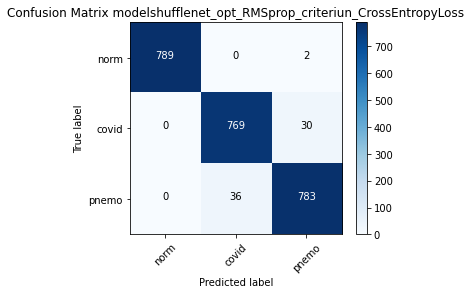

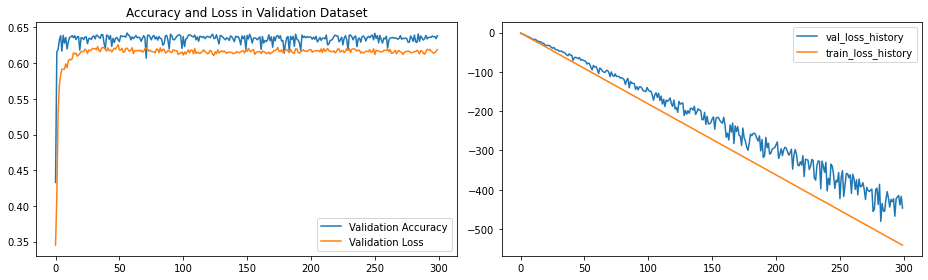


==== END ====
[[758  33   0]
 [ 10 789   0]
 [344 475   0]]

Sensitivity or recall total
0.6421751764217518

Sensitivity or recall per classes
[0.96 0.99 0.  ]

Precision
[0.68 0.61 0.  ]

F1 Score
[0.8  0.75 0.  ]
Confusion matrix, without normalization


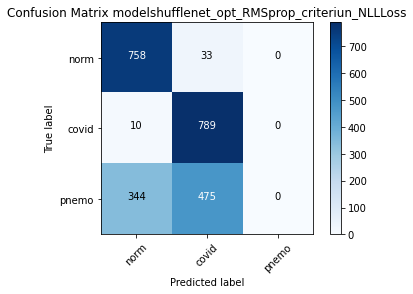

In [11]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['shufflenet'] #['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg', 'googlenet', 'shufflenet', 'mobilenet' ]
lrs = [1e-4]
_epoch = [300]
batch_sizes = [8]
opt = [1, 2, 3]
crt = [1, 2]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                         
                        
                            
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        
                        
                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
                        if _opt == 3:
                            optimizer_ft = optim.RMSprop(params_to_update, _lrs)
                            opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                        #tray nn.NLLLoss
                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'CrossEntropyLoss'
                        if _crt == 2:
                            criterion = nn.NLLLoss()
                            crt_name = 'NLLLoss'

                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)
                        
                        

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 3

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], 
                        title='Confusion Matrix model'+_model+'_opt_'+opt_name+'_criteriun_'+crt_name)




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [42]:
model_ft.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
########## CAM try 1

In [ ]:
# # hook the feature extractor
# features_blobs = []
# def hook_feature(module, input, output):
#     features_blobs.append(output.data.cpu().numpy())

# model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

# # get the softmax weight
# params = list(model_ft.parameters())
# weight_softmax = np.squeeze(params[-2].data.numpy())

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     bz, nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(cv2.resize(cam_img, size_upsample))
#     return output_cam


In [ ]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# img_pil.save('test.jpg')

# img_tensor = preprocess(img_pil)
# img_variable = Variable(img_tensor.unsqueeze(0))
# logit = model_ft(img_variable)

# # download the imagenet category list
# # classes = {int(key):value for (key, value)
# #           in requests.get(LABELS_URL).json().items()}

# # h_x = F.softmax(logit, dim=1).data.squeeze()
# # probs, idx = h_x.sort(0, True)
# # probs = probs.numpy()
# # idx = idx.numpy()

# # # output the prediction
# # for i in range(0, 5):
# #     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# # generate class activation mapping for the top1 prediction
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# # render the CAM and output
# # print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# img = cv2.imread('test.jpg')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM.jpg', result)

In [ ]:
# import IPython.display as display
# from PIL import Image
# image_path = 'CAM.jpg'
# display.display(Image.open(image_path))

In [ ]:
########## CAM try 1 FIIMMMM

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [ ]:
# savePath = "test_model.pth"
# torch.save(model_ft.state_dict(), savePath)

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
#TRY CAM
#do it using RESNET

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
from torch.autograd import Variable

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
transformers = {
    'train_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'valid_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

trans = ['train_transforms','valid_transforms','test_transforms']

path = "/home/jimi/dissertacao/covid19/datasets/80-20/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x,
                                             transform=transformers[y]) for x,y in zip(categories, trans)}

dataset_sizes = ['train']


num_threads = 4 
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories}

dataset_sizes = {x : len(dset[x]) for x in ['train','val','test']}

class_names = dset['train'].classes

#class_names = image_datasets['train'].classes

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
##### RESNET
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,3),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = True
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        if train_on_gpu:
            self.model = self.model.cuda()
            
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model
    
model = Model()
model_ft = model.fit(dataloaders,300)

from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


from sklearn import metrics

#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))




epoch 1/300
----------
train loss:  0.2861  acc: 0.8961
val loss:  0.1513  acc: 0.9481
epoch 2/300
----------
train loss:  0.1862  acc: 0.9335
val loss:  0.1124  acc: 0.9606
epoch 3/300
----------
train loss:  0.1733  acc: 0.9355
val loss:  0.1183  acc: 0.9597
epoch 4/300
----------
train loss:  0.1353  acc: 0.9514
val loss:  0.1139  acc: 0.9589
epoch 5/300
----------
train loss:  0.1371  acc: 0.9514
val loss:  0.1076  acc: 0.9618
epoch 6/300
----------
train loss:  0.1363  acc: 0.9499
val loss:  0.1058  acc: 0.9626
epoch 7/300
----------
train loss:  0.1365  acc: 0.9512
val loss:  0.1081  acc: 0.9606
epoch 8/300
----------


In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





In [ ]:
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()

plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], title='Confusion matrix')

In [ ]:
data_dir_test = "/home/jimi/dissertacao/covid19/datasets/80-20/test/"

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [ ]:
model_ft.eval()

In [ ]:
#print(model)

In [ ]:
#print(model_ft)

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
# plot predictions
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    
    #print (f'index: {index}')
    #print (f'image: {image}')
    #print (f'labes: {labels}')
    #print (f'classes index :{classes[index]}')
    #print (f'classes 2:{classes}')
    
    sub = fig.add_subplot(8, 4, ii+1)
    
    #print()
    res = int(labels[ii]) == 1
    #print(f'int(labels[ii]): {int(labels[ii])}')
    #print(f'index: {index}')
    #print(f'res = int(labels[ii]) == index: {res}')
    #print()
    
    #print (f'res : {res}')
    
    sub.set_title(str(classes[1]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/1785.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/860.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/2480.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-9-a.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-10.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 2 FIIMMMM

In [22]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 3 ref - https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19
########## CAM try 3 ref
########## CAM try 3 ref
########## CAM try 3 ref

In [ ]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        cmap = cm.get_cmap("rainbow")
        c = cmap(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.show()
    plt.pause(0.01)

def data_viz(layer, label):
    # https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/401_CNN.ipynb
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(layer.data.numpy()[:plot_only, :])
    labels = label.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labels)


def plot_test_image_result(img, ps, le, cam=None):

    _ = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    if cam is not None:
        ax1.imshow(cam, alpha=0.6)
        ax1.imshow(img, alpha=0.4)
    else:
        ax1.imshow(img)

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))

    for i, v in enumerate(ps):
        ax2.text(
            .01,
            i-0.1,
            f'{v:.3f}',
            color='blue',
            fontweight='bold')

    if le is None:
        ax2.set_yticklabels(np.arange(len(ps)))
    else:
        ax2.set_yticklabels(le.inverse_transform(np.arange(len(ps))))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# makedataset.py

from os.path import isfile, join
from os import walk
import pandas as pd
import numpy as np
from itertools import tee

from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    path = "./data"
    sample_per_category = 500
    seed = 24
    split_frac = 0.20

    df_raw = None

    genFiles = (
        (dirpath, dirnames, filenames) for (dirpath, dirnames, filenames) in walk(path)
    )

    files, genFiles = tee(genFiles)
    file_count = sum(len(f) for _, _, f in files)

    df_raw = pd.DataFrame(
        data=np.nan, index=np.arange(0, file_count - 1), columns=["LABEL", "FILE"]
    )

    files, genFiles = tee(genFiles)
    idx = 0
    for r, _, f in files:
        for _f in f:
            if isfile(join(r, _f)) and _f.endswith(
                (".jpeg", ".png", "jpg", ".JPEG", ".PNG", "JPG")
            ):
                path = "/".join((r, _f))
                *_, label = r.split("/")
                df_raw.iloc[idx] = [label, path]
                idx += 1

    df_raw.to_csv("./data/raw.csv", index=False)

    # # 3-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 3),
        columns=["FILE", "LABEL"],
    )

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/3_class_train_df.csv", index=False)
    test_df.to_csv("./data/3_class_test_df.csv", index=False)

    print(f"\n3_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"3_class_test_df:\n{test_df['LABEL'].value_counts()}")

    # 2-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 2),
        columns=["FILE", "LABEL"],
    )

    index = df_raw[df_raw["LABEL"] == "pneumonia"].index
    df_raw.drop(index, inplace=True)

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/2_class_train_df.csv", index=False)
    test_df.to_csv("./data/2_class_test_df.csv", index=False)

    print(f"\n2_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"2_class_test_df:\n{test_df['LABEL'].value_counts()}")

In [ ]:
# architectures.py

import torch.nn as nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Rn50(nn.Module):
    def __init__(self, device, train_base=False, classes=2):
        super(Rn50, self).__init__()

        self.device = device

        self.net_back = resnet50(pretrained=True).to(self.device)
        self._trainable(train_base)

        fc_size = self.net_back.fc.in_features
        self.net_back.fc = Identity()

        self.net_head = nn.Sequential(
            nn.Linear(in_features=fc_size, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=classes),
            nn.LogSoftmax(dim=1),
        ).to(self.device)

    def forward(self, x):
        x = self.net_back(x.to(self.device))
        x = x.view(x.size(0), -1)
        return self.net_head(x.to(self.device))

    def _trainable(self, flag):
        for param in self.net_back.parameters():
            param.requires_grad = flag


# old way
# modules = list(resnet50(pretrained=True).children())[:-1]
# self.net_back = nn.Sequential(*modules).to(self.device)
# fc_size = list(self.net_back.parameters())[-1].size(0)
# self.net_head = nn.Sequential(...).to(self.device)

In [ ]:
# activationmap.py

import torch


class FeatureBuffer():

    features=None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # self.features = ((output.cpu()).data).numpy()
        self.features = output

    def remove(self):
        self.hook.remove()


# def GradCam(model, input_image_tensor):

#     https://github.com/tyui592/class_activation_map/blob/master/cam.py
#     https://github.com/daixiangzi/Grad_Cam-pytorch-resnet50/blob/578db29d13b0e7d17aa53d9bac116674771618ec/test_grad_cam.py#L19
#     https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
#     https://github.com/MarcoCBA/Class-Activation-Maps-PyTorch/blob/master/class_activation_maps.ipynb

#     print(model)

#     final_conv_layer = model.net_back._modules.get('layer4')
#     fc_layer = model.net_head._modules.get('0')
#     fb = FeatureBuffer(final_conv_layer)

#     model = model.eval()
#     out = model(input_image_tensor)

#      # based on model caluculate output!!!
#     probabilities = torch.exp(out)
#     _, predicted = torch.max(probabilities, 1)
#     feature_maps = fb.features

#     print("Output's shape: ", out.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     weights_and_biases = list(fc_layer.parameters())
#     class_weights = weights_and_biases[0][predicted]
#     print("Weights's shape: ", weights_and_biases[0].shape)
#     print("Biases's shape: ", weights_and_biases[1].shape)
#     print("Class weights's shape :", class_weights.shape)

#     class_weights = class_weights.reshape((-1, 1, 1))
#     feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
#     print("Class weights's shape :", class_weights.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(class_activation_maps)
#     plt.show()

#     resized_cam = cv2.resize(class_activation_maps, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(resized_cam)
#     plt.show()

In [ ]:
# train.py

import math
from time import time
from copy import deepcopy

import torch

try:
    from torchsummary import summary
except:
    MODELSUMMARY = False
else:
    MODELSUMMARY = True

try:
    from sklearn.manifold import TSNE
except:
    VIZTSNE = False
else:
    VIZTSNE = True


def train_model(
    model,
    device,
    criterion,
    optimizer,
    dataloaders,
    dataloader_len,
    input_shape,
    scheduler=None,
    num_epochs=50,
):

    if MODELSUMMARY:
        summary(model, input_data=input_shape)

    start = time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t_epoch = time()
        print(f"epoch: {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for idx, (labels, inputs) in enumerate(dataloaders[phase]):
                iter_batch = math.ceil(
                    dataloader_len[phase] / dataloaders[phase].batch_size
                )
                print(f"[phase: {phase}] batch: {idx+1}/{iter_batch}", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / dataloader_len[phase]
            epoch_acc = running_corrects.double() / dataloader_len[phase]
            print(f"[phase: {phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                print(f"[saving model] epoch: {epoch+1} Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        t_elapsed = time() - t_epoch
        print(f"epoch training complete in {t_elapsed//60:.0f}m {t_elapsed%60:.0f}s")
        print()

    time_elapsed = time() - start
    print(f"training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    checkpoint = {
        "input_shape": input_shape,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    torch.save(checkpoint, "./models/checkpoint.pth")
    return model

In [ ]:
# test.py

import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scripts.activationmap import FeatureBuffer
from sklearn.metrics import classification_report, confusion_matrix

#from .utils import plot_test_image_result


def test_model(model, testloader, device, encoder=None):

    correct = 0
    total = 0
    true_list = list()
    pred_list = list()

    for idx, (labels, inputs) in enumerate(testloader):
        iter_batch = math.ceil(len(testloader.dataset)/testloader.batch_size)
        print(f'[phase: test] batch: {idx+1}/{iter_batch}', end='\r')

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probabilities = torch.exp(outputs)
            _, predicted = torch.max(probabilities, 1)

            total = idx + 1
            correct += torch.sum(predicted == labels.data)
            true_list.append((labels.data.cpu()).numpy().item())
            pred_list.append((predicted.cpu()).numpy().item())

    acc = 100*(correct.item()/total)
    print(f"[phase: test] total: {total}, correct: {correct}, acc: {acc:.3f}")

    print(classification_report(tuple(true_list), tuple(pred_list)))

    y_true = pd.Series(true_list, name='Actual')
    y_pred = pd.Series(pred_list, name='Predicted')
    cm = pd.crosstab(y_true, y_pred,  margins=True)

    print("confusion matrix")
    if encoder is not None:
        print({i : encoder.classes_[i] for i in range(0, len(encoder.classes_))})
    print(cm)



def test_image(model, image, in_shape, transform, device, labelencoder=None, cam=None):
    """
    GradCam
    """

    if cam is not None:
        final_conv_layer = model.net_back._modules.get('layer4')
        fc_layer = model.net_head._modules.get('0')
        fb = FeatureBuffer(final_conv_layer)

    input_tensor = transform(image).unsqueeze(0)
    inputs = input_tensor.to(device)

    model = model.eval()
    outputs = model(inputs)
    probabilities = torch.exp(outputs)
    prob = (probabilities.cpu()).detach().numpy().flatten()

    if cam is not None:
        _, predicted = torch.max(probabilities, 1)
        feature_maps = fb.features

        weights_and_biases = list(fc_layer.parameters())
        class_weights = weights_and_biases[0][predicted]

        class_weights = class_weights.reshape((-1, 1, 1))
        feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)

        class_activation_maps = np.array(
            torch.sum(feature_maps * class_weights, dim=0).cpu().detach(),
            dtype=np.float32)

        cam_map = cv2.resize(
            class_activation_maps,
            dsize=in_shape,
            interpolation=cv2.INTER_LANCZOS4)

    if cam is not None:
        plot_test_image_result(image.resize(in_shape), prob, labelencoder, cam_map)
    else:
        plot_test_image_result(image, prob, labelencoder)

In [ ]:
# evaluate.py 

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from PIL import Image

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.test import test_model, test_image


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"

test_file = "data/3_class_test_df.csv"
image_file = "data/raw/covid/covid_001.jpg"
num_workers = 2
batch_size = 1
input_shape = (256, 256)
le = LabelEncoder()

df = pd.read_csv(test_file)

test_transforms = transforms.Compose(
    [
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_set = Datagen(df, l_encoder=le, transforms=test_transforms)
label_enc = test_set.get_le()
device = get_device()

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers,
)

model = Rn50(device=device, classes=3)
model.load_state_dict(torch.load("./models/checkpoint.pth")["state_dict"])

test_model(
    model=model,
    testloader=test_loader,
    device=device,
    encoder=label_enc)

input_image = Image.open(image_file).convert("RGB")
test_image(
    model=model,
    image=input_image,
    in_shape=input_shape,
    transform=test_transforms,
    device=device,
    labelencoder=label_enc,
    cam=True
)

In [ ]:
# datagen.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image


class Datagen(Dataset):
    def __init__(self, dataframe, transforms=None, l_encoder=None):
        self.df = dataframe
        self.transforms = transforms
        self.encoder = l_encoder

        if self.encoder is not None:
            self.df["LABEL"] = self.encoder.fit_transform(self.df["LABEL"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.df.iloc[idx, 0]
        image_file = self.df.iloc[idx, 1]
        image = Image.open(image_file).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # print(image.shape)
        return (label, image)

    def get_le(self):
        return self.encoder

In [ ]:
# trainer.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.train import train_model


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"


train_file = "data/3_class_train_df.csv"
num_workers = 2
val_split = 0.2
batch_size = 32
num_epochs = 20
input_shape = (3, 256, 256)
le = LabelEncoder()

df = pd.read_csv(train_file)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = Datagen(df, l_encoder=le, transforms=train_transforms)
validation_set = Datagen(df, l_encoder=le, transforms=validation_transforms)

train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(
    train_set,
    # shuffle=True,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    # shuffle=False,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)

device = get_device()
net = Rn50(device=device, classes=3)

dataloaders = {"train": train_loader, "val": valid_loader}
dataloader_len = {"train": len(train_idx), "val": len(val_idx)}

criteration = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(
    model=net,
    device=device,
    criterion=criteration,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataloader_len=dataloader_len,
    input_shape=input_shape,
    num_epochs=num_epochs,
)

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM

In [ ]:
########## CAM functional

In [2]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.2966908:1594933666/ferramenta-sesa.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#net.eval()

In [ ]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable) ## aqui tem algo

# # download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# # output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

In [ ]:
import IPython.display as display
from PIL import Image
image_path = 'CAM.jpg'
display.display(Image.open(image_path))

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [12]:
model_ft = GoogLeNet.from_pretrained('googlenet')
# ... image preprocessing as in the classification example ...
inputs = torch.randn(1, 3, 224, 224)
print(inputs.shape) # torch.Size([1, 3, 224, 224])

feature_extract = model_ft.extract_features(inputs)
print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

model_ft.eval()

Loaded pretrained weights for googlenet
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024, 7, 7])


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
model_ft = models.shufflenet_v2_x1_0(pretrained=True)
model_ft.Layers
# # ... image preprocessing as in the classification example ...
# inputs = torch.randn(1, 3, 224, 224)
# print(inputs.shape) # torch.Size([1, 3, 224, 224])

# feature_extract = model_ft.extract_features(inputs)
# print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

# model_ft.eval()

AttributeError: 'ShuffleNetV2' object has no attribute 'Layers'

In [15]:
model_ft = models.shufflenet_v2_x1_0(pretrained=True)
# ... image preprocessing as in the classification example ...
inputs = torch.randn(1, 3, 224, 224)
print(inputs.shape) # torch.Size([1, 3, 224, 224])

feature_extract = model_ft.fc(inputs)
print(feature_extract.shape) # torch.Size([1, 1024, 7, 7])

model_ft.eval()

torch.Size([1, 3, 224, 224])


RuntimeError: size mismatch, m1: [672 x 224], m2: [1024 x 1000] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41